# Libray matching with DreaMS

## Introduction

According to the results presented in our [paper]((https://chemrxiv.org/engage/chemrxiv/article-details/6626775021291e5d1d61967f)), DreaMS embeddings provide a more accurate way to perform library matching than traditional algorithms such as modified cosine similarity or spectral entropy. Library matching is the annotation of a query spectrum with a molecule corresponding to the most similar spectrum in some given spectral library. In this tutorial, we will demonstrate how to perform library matching with DreaMS embeddings using the [MassSpecGym](https://github.com/MassSpecGym/MassSpecGym) dataset as a library, which contains a curated collection of public high-quality MS/MS spectra.

Import necessary libraries.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from rdkit import Chem
import dreams.utils.spectra as su
import dreams.utils.io as io
from dreams.utils.spectra import PeakListModifiedCosine
from dreams.utils.data import MSData
from dreams.api import dreams_embeddings
from dreams.definitions import *

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## Load data

Load example dataset downloaded from [MSV000086206](https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=11fbd0d4c9144a6c813b196d865567ab) and [MassSpecGym library with pre-computed DreaMS embeddings](https://huggingface.co/datasets/roman-bushuiev/GeMS/blob/main/data/auxiliary/MassSpecGym_DreaMS.hdf5).

In [3]:
in_pth = Path('../data/S_N1.mzML')  # Example dataset
lib_pth = Path('../data/MassSpecGym_DreaMS.hdf5')  # MassSpecGym library

In [4]:
msdata_lib = MSData.load(lib_pth)
embs_lib = msdata_lib[DREAMS_EMBEDDING]
print('Shape of the library embeddings:', embs_lib.shape)

Shape of the library embeddings: (231104, 1024)


In [6]:
msdata = MSData.load(in_pth)
embs = dreams_embeddings(msdata)
print('Shape of the query embeddings:', embs.shape)

Computing DreaMS embedding: 100%|██████████| 3809/3809 [01:42<00:00, 37.22it/s]

Shape of the query embeddings: (3809, 1024)


## Perform library matching

Compute all cosine similarity between the query and library DreaMS embeddings.

In [7]:
sims = cosine_similarity(embs, embs_lib)
sims.shape

(3809, 231104)

Choose top-k candidates with the highest similarity per query spectrum.

In [8]:
k = 5
topk_cands = np.argsort(sims, axis=1)[:, -k:][:, ::-1]
topk_cands.shape

(3809, 5)

Organize the results in a DataFrame with the most important library metadata, such as library SMILES.

In [15]:
# Construct a DataFrame with the top-k candidates for each spectrum and their corresponding similarities
df = []
cos_sim = su.PeakListModifiedCosine()
for i, topk in enumerate(tqdm(topk_cands)):
    for n, j in enumerate(topk):
        df.append({
            'feature_id': i + 1,
            'precursor_mz': msdata.get_values(PRECURSOR_MZ, i),
            'RT': msdata.get_values(RT, i),
            'topk': n + 1,
            'library_j': j,
            'library_SMILES': msdata_lib.get_smiles(j),
            'library_ID': msdata_lib.get_values('IDENTIFIER', j),
            'library_precursor_mz': msdata_lib.get_values(PRECURSOR_MZ, j),
            'library_adduct': msdata_lib.get_values(ADDUCT, j),
            'library_collision_energy': msdata_lib.get_values('COLLISION_ENERGY', j),
            'DreaMS_similarity': sims[i, j],
            'Modified_cosine_similarity': cos_sim(
                spec1=msdata.get_spectra(i),
                prec_mz1=msdata.get_prec_mzs(i),
                spec2=msdata_lib.get_spectra(j),
                prec_mz2=msdata_lib.get_prec_mzs(j),
            ),
            'i': i,
            'j': j,
        })
df = pd.DataFrame(df)

# Sort hits by DreaMS similarity
df_top1 = df[df['topk'] == 1].sort_values('DreaMS_similarity', ascending=False)
df = df.set_index('feature_id').loc[df_top1['feature_id'].values].reset_index()
df

100%|██████████| 3809/3809 [03:29<00:00, 18.17it/s]


,feature_id,precursor_mz,RT,topk,library_j,library_SMILES,library_ID,library_precursor_mz,library_adduct,library_collision_energy,DreaMS_similarity,Modified_cosine_similarity,i,j
0,344,565.235133,185.953374,1,217668,CC(=O)N(CCCC[C@@H](C(=O)O)NC(=O)CC(CC(=O)N[C@@...,MassSpecGymID0396609,565.23000,[M+H]+,NaN,0.979676,0.999883,343,217668
1,344,565.235133,185.953374,2,156591,CC1=C2C(=NC=NN2C=C1NC(=O)OC[C@@H]3COCCN3)NC4=C...,MassSpecGymID0225965,531.22629,[M+H]+,20.0,0.609247,0.643832,343,156591
2,344,565.235133,185.953374,3,161476,CN1C2=C(C=CC(=C2)C3=CC=C(C=C3)C[C@@H](C#N)NC(=...,MassSpecGymID0231755,421.18703,[M+H]+,30.0,0.601104,0.488964,343,161476
3,344,565.235133,185.953374,4,135639,CCC1=CC(=C(S1)NC(=O)CCN2CCOCC2)C(=O)OCC,MassSpecGymID0203635,341.15295,[M+H]+,20.0,0.595223,0.664075,343,135639
4,344,565.235133,185.953374,5,155803,CC(=O)NCCCOC1=CC=C(C=C1)C(=O)N2CCC(CC2)N3C(=O)...,MassSpecGymID0225137,450.23873,[M+H]+,30.0,0.570048,0.725630,343,155803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19040,1789,237.110323,476.531454,1,104889,CC(=CCOC1=C2C=CC(=O)OC2=CC3=C1C=CO3)C,MassSpecGymID0151614,293.08000,[M+Na]+,NaN,0.342242,0.831349,1788,104889
19041,1789,237.110323,476.531454,2,181939,CC1=C(N2C(C(C2=O)[NH3+])SC1)C(=O)[O-],MassSpecGymID0268406,237.03000,[M+Na]+,NaN,0.328011,0.700030,1788,181939
19042,1789,237.110323,476.531454,3,181941,CC1=C(N2C(C(C2=O)[NH3+])SC1)C(=O)[O-],MassSpecGymID0268414,237.03000,[M+Na]+,NaN,0.327554,0.809387,1788,181941
19043,1789,237.110323,476.531454,4,104897,CC(=CCOC1=C2C=CC(=O)OC2=CC3=C1C=CO3)C,MassSpecGymID0151624,293.08000,[M+Na]+,NaN,0.327202,0.737573,1788,104897


Store results to CSV file.

In [16]:
df.to_csv(io.append_to_stem(in_pth, 'MassSpecGym_hits').with_suffix('.csv'), index=False)

## Library matching results

Let's look at the retrieved library spectra for our query spectra. First, let's look at the confidently matched spectrum with a high DreaMS similarity.

Library ID: MassSpecGymID0236163 (top 1 hit)
Query precursor m/z: 230.18643445964, Library precursor m/z: 230.1863
DreaMS similarity: 0.8856791257858276
Modified cosine similarity: 0.9892408193123613


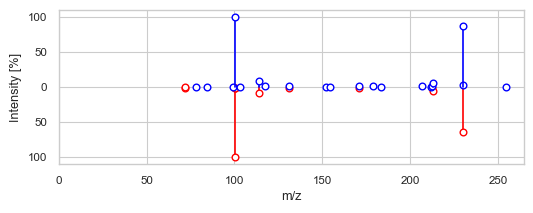

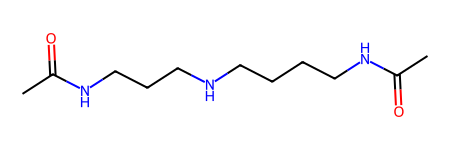

Library ID: MassSpecGymID0236162 (top 2 hit)
Query precursor m/z: 230.18643445964, Library precursor m/z: 230.1863
DreaMS similarity: 0.8603854179382324
Modified cosine similarity: 0.7990432320842271


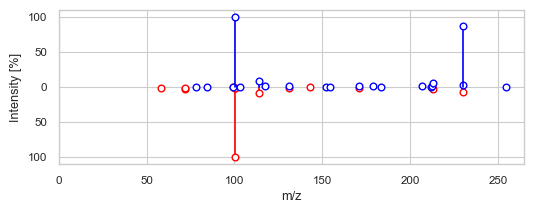

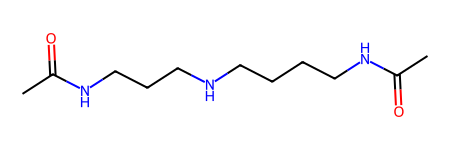

Library ID: MassSpecGymID0236161 (top 3 hit)
Query precursor m/z: 230.18643445964, Library precursor m/z: 230.1863
DreaMS similarity: 0.7787462472915649
Modified cosine similarity: 0.716395852717653


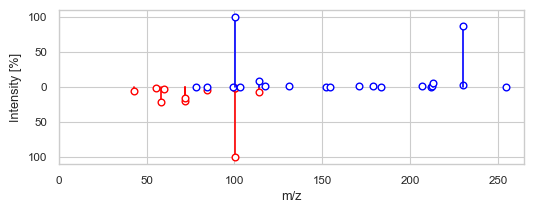

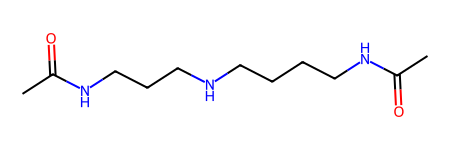

Library ID: MassSpecGymID0391831 (top 4 hit)
Query precursor m/z: 230.18643445964, Library precursor m/z: 230.223
DreaMS similarity: 0.6461858749389648
Modified cosine similarity: 0.1537209674611311


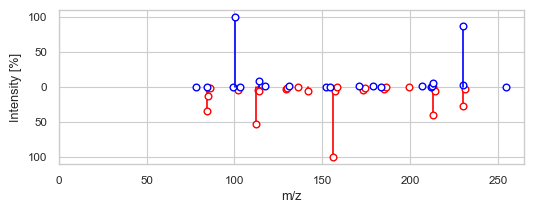

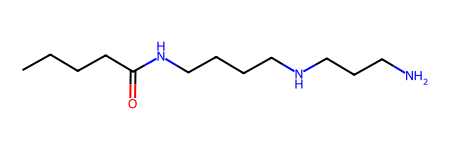

Library ID: MassSpecGymID0391832 (top 5 hit)
Query precursor m/z: 230.18643445964, Library precursor m/z: 230.223
DreaMS similarity: 0.6406431198120117
Modified cosine similarity: 0.09253357021617656


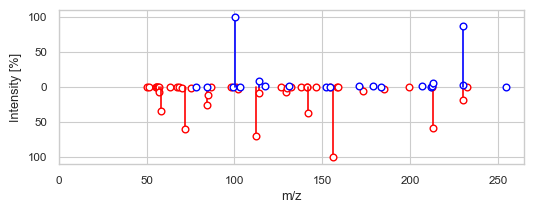

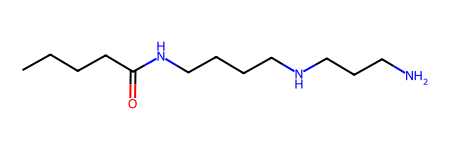

In [17]:
i = df_top1['i'].iloc[25]
df_i = df[df['i'] == i]
for _, row in df_i.iterrows():
    i, j = row['i'], row['j']
    print(f'Library ID: {row["library_ID"]} (top {row["topk"]} hit)')
    print(f'Query precursor m/z: {msdata.get_prec_mzs(i)}, Library precursor m/z: {msdata_lib.get_prec_mzs(j)}')
    print('DreaMS similarity:', row['DreaMS_similarity'])
    print('Modified cosine similarity:', row['Modified_cosine_similarity'])
    su.plot_spectrum(spec=msdata.get_spectra(i), mirror_spec=msdata_lib.get_spectra(j))
    display(Chem.MolFromSmiles(row['library_SMILES']))

The top-1 hit demonstrates a strong match, aligning well with the modified cosine similarity. However, annotating a query spectrum with a library spectrum is often impossible due to the limited size of available libraries. In such instances, DreaMS similarity offers an interesting approach, providing insights into the molecular structure even without a definitive match. Let's examine a case with a less confident hit to illustrate this concept.

Library ID: MassSpecGymID0240559 (top 1 hit)
Query precursor m/z: 186.980925613972, Library precursor m/z: 187.123
DreaMS similarity: 0.3821600675582886
Modified cosine similarity: 0.005611964348858777


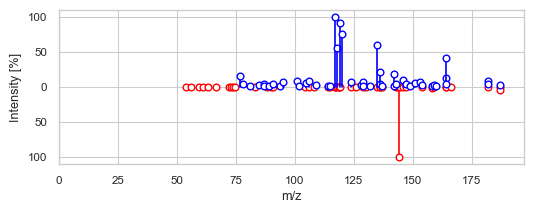

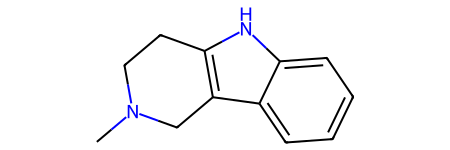

Library ID: MassSpecGymID0015768 (top 2 hit)
Query precursor m/z: 186.980925613972, Library precursor m/z: 146.0116
DreaMS similarity: 0.3812687397003174
Modified cosine similarity: 0.1472003166482408


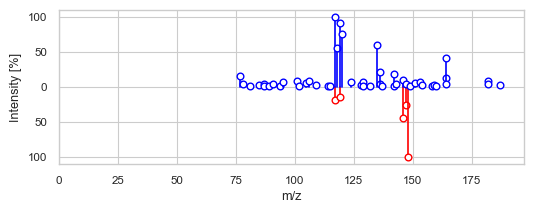

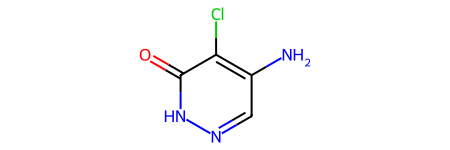

Library ID: MassSpecGymID0079643 (top 3 hit)
Query precursor m/z: 186.980925613972, Library precursor m/z: 146.0712736972
DreaMS similarity: 0.37886130809783936
Modified cosine similarity: 0.07692617816195739


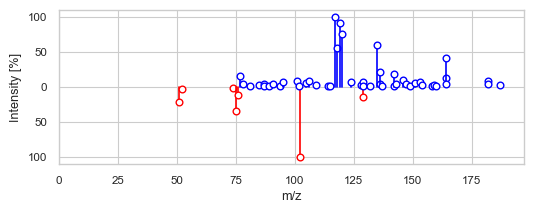

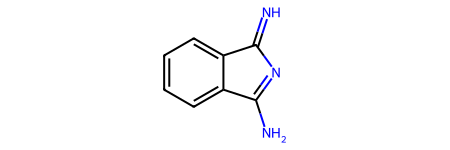

Library ID: MassSpecGymID0117726 (top 4 hit)
Query precursor m/z: 186.980925613972, Library precursor m/z: 187.0865894
DreaMS similarity: 0.3684600591659546
Modified cosine similarity: 0.14840001932798705


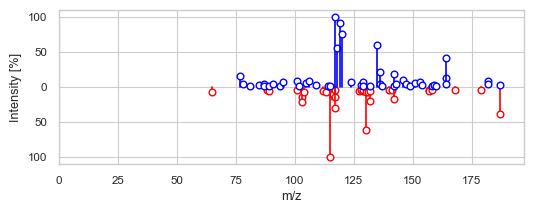

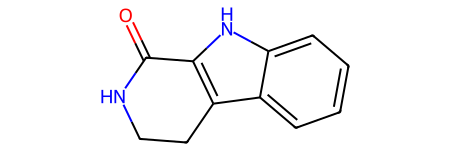

Library ID: MassSpecGymID0117714 (top 5 hit)
Query precursor m/z: 186.980925613972, Library precursor m/z: 187.0865894
DreaMS similarity: 0.36845511198043823
Modified cosine similarity: 0.1485209819270144


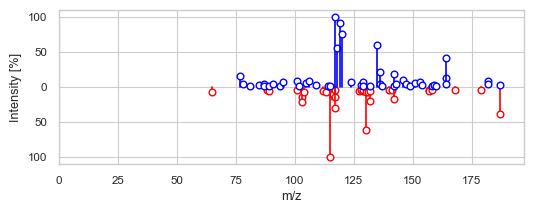

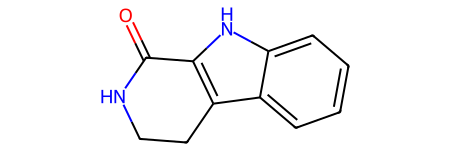

In [32]:
i = df_top1['i'].iloc[-5]
df_i = df[df['i'] == i]
for _, row in df_i.iterrows():
    i, j = row['i'], row['j']
    print(f'Library ID: {row["library_ID"]} (top {row["topk"]} hit)')
    print(f'Query precursor m/z: {msdata.get_prec_mzs(i)}, Library precursor m/z: {msdata_lib.get_prec_mzs(j)}')
    print('DreaMS similarity:', row['DreaMS_similarity'])
    print('Modified cosine similarity:', row['Modified_cosine_similarity'])
    su.plot_spectrum(spec=msdata.get_spectra(i), mirror_spec=msdata_lib.get_spectra(j))
    display(Chem.MolFromSmiles(row['library_SMILES']))

While the query spectrum cannot be confidently matched to any known library spectrum, the top five hits reveal a consistent pattern: all retrieved molecules, though small in size, contain at least two nitrogen atoms. This observation suggests that the unknown compound represented by the query spectrum is nitrogen-rich. Even without a definitive match, we can still formulate a structural hypothesis for the unknown compound.

## Even faster search via approximate nearest neighbors

To achieve even faster library matching, we can use the approach of approximate nearest neighbors (ANN). In this example, we'll utilize the [PyNNDescent](https://pynndescent.readthedocs.io/en/latest/index.html) library. However, since DreaMS embeddings are 1024-dimensional vectors, they can be seamlessly integrated with any other vector database of your choice for efficient similarity search or other applications (e.g., clustering or visualization).

In [33]:
# Build an index for the library
import pynndescent
index = pynndescent.NNDescent(embs_lib, metric='cosine', n_neighbors=50)

In [ ]:
# Approximate nearest neighbors search for i-th spectrum (note that the first query may be slow)
neighbors = index.query(embs[[i]])
pd.DataFrame({
    'j': neighbors[0][0],
    'DreaMS_similarity': 1 - neighbors[1][0]  # Convert distances to similarities
})

,j,DreaMS_similarity
0,168540,0.382160
1,62809,0.378861
2,89593,0.368460
3,89581,0.368455
4,117184,0.356404
5,117183,0.355120
6,89605,0.354955
7,41768,0.348629
8,84511,0.347867
9,84520,0.347862


In [35]:
# Exact nearest neighbors search for i-th spectrum
df_i[['j', 'DreaMS_similarity']]

,j,DreaMS_similarity
19020,168540,0.382160
19021,12627,0.381269
19022,62809,0.378861
19023,89593,0.368460
19024,89581,0.368455


As we can see, the result of the ANN search is very similar to the exact nearest neighbors search (top 1 hit is identical). However, the ANN search is much faster, especially for large libraries.